<a href="https://colab.research.google.com/github/giuliaries/MachineLearning/blob/main/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Giulia Santoiemma](mailto:giulia.santoiemma@studenti.unipd.it) 2004775<br/>
Machine Learning<br/> 
Master Degree in Computer Science<br/>
27 December 2021

# Clustering

In this notebook I will test the clustering methods seen in class available within the scikit-learn library, comparing them using the metrics seen during the course.

Clustering is the process of grouping a set of objects into groups of similar objects.
It is the most common analytical technique among unsupervised learning techniques.
Unlike supervised learning, the classifications of the set of examples (training set) are not present.

The skill of clustering techniques is to find similarities between objects of the same group.
In several approaches, the concept of similarity is represented as a distance in a multidimensional space.
Hence, clustering algorithms group objects by their mutual distance (the concept of similarity).
So membership in a set depends on how far an object is from the cluster itself.

In [1]:
# Import libraries
from google.colab import files
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, homogeneity_score
from sklearn.metrics.cluster import contingency_matrix
from tabulate import tabulate

import numpy as np
import pandas as pd
import pylab as pl
import scipy.cluster.hierarchy as h

## Dataset

I used the S3 dataset for clustering of the S-set section from [Clustering basic benchmark](http://cs.joensuu.fi/sipu/datasets/)

In [2]:
# Import:
# - s3.txt file with dataset
# - s3-label.pa file with Ground Truth centroids and partitions
uploaded = files.upload()

Saving s3-label.pa to s3-label.pa
Saving s3.txt to s3.txt


In [3]:
# Read the txt file and show the first and last rows of the dataset
X = pd.read_csv("./s3.txt", delim_whitespace=True, header=None)
X

,0,1
0,453320,606542
1,520651,594591
2,516664,660290
3,570023,570741
4,524035,518443
...,...,...
4995,361134,191237
4996,393818,302840
4997,351482,334662
4998,341057,341338


In [4]:
# Read the file with Ground Truth partitions
y = pd.read_csv("s3-label.pa", delim_whitespace=True, skiprows=4)
y

,-------------------------------------
0,1
1,1
2,1
3,1
4,1
...,...
4995,15
4996,15
4997,15
4998,15


In [5]:
y_true = y.to_numpy().reshape(5000,)
y_true

array([ 1,  1,  1, ..., 15, 15, 15])

## Metrics

Metrics used to verify clustering accuracy.

I define them all in a function in order to call them for each type of clustering.

In [6]:
# List to show the data
headers = ["Clustering"]
report = [
  {"label": "Purity"},
  {"label": "Adjusted RandIndex"},
  {"label": "Adjusted Mutual Information"},
  {"label": "Homogeneity"}
]

# Compute the Purity:
# the ratio between the number of elements of the dominant class in a cluster and the cardinality of the cluster.
def purity_score(y_true, y_pred):
  # compute contingency matrix (also called confusion matrix)
  cmatrix = contingency_matrix(y_true, y_pred)
  # return purity
  return np.sum(np.amax(cmatrix, axis=0)) / np.sum(cmatrix) 

# Get metrics
def get_metrics(labels_true, labels_pred, label):
  # Purity
  purity = purity_score(labels_true, labels_pred)
  report[0][label] = purity
  print("Purity: ", purity)

  # Rand index adjusted for chance.
  # The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples
  # and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.
  # The adjusted Rand index is thus ensured to have a value
  # close to 0.0 for random labeling independently of the number of clusters and samples 
  # and exactly 1.0 when the clusterings are identical (up to a permutation).
  ari = adjusted_rand_score(labels_true, labels_pred)
  report[1][label] = ari
  print("Adjusted RandIndex: ", ari)

  # Adjusted Mutual Information (AMI) is an adjustment of the Mutual Information (MI) score to account for chance. 
  # It accounts for the fact that the MI is generally higher for two clusterings with a larger number of clusters, 
  # regardless of whether there is actually more information shared.
  ami = adjusted_mutual_info_score(labels_true, labels_pred)
  report[2][label] = ami
  print("Adjusted Mutual Information: ", ami)

  # Homogeneity metric of a cluster labeling given a ground truth.
  # A clustering result satisfies homogeneity if all of its clusters contain only data points which are members of a single class.
  # This metric is independent of the absolute values of the labels:
  # a permutation of the class or cluster label values won’t change the score value in any way.
  homogeneity = homogeneity_score(labels_true, labels_pred)
  report[3][label] = homogeneity
  print("Homogeneity: ", homogeneity)

## Algorithm

### K-means Algorithm

I start by using the K-Means algorithm implemented by scikit-learn.

This algorithm requires a number `k` of clusters to be formed, fixed a priori, in this case initialized to 15.
This number derives from the fact that the data in the dataset was formed using 15 Gaussian distributions.

The `n_init` parameter indicates the number of times the algorithm will be started under different centroids.
The returned result will be the best of these.
After testing various values, I chose 10, as the clusters formed do not differ much from those generated by higher parameters.

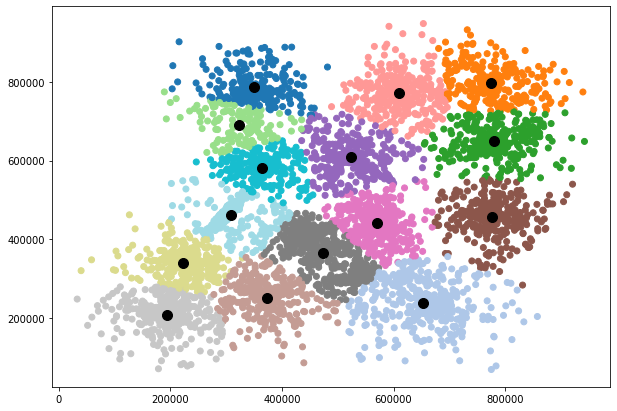

Purity:  0.808
Adjusted RandIndex:  0.6764024034422383
Adjusted Mutual Information:  0.7772315073897443
Homogeneity:  0.7744916028632866
Inertia:  18704516914299.125


In [7]:
# K-Means clustering
km = KMeans(n_clusters=15, init="random", n_init=10)

# Compute k-means clustering
km.fit(X)

# Show clustering
pl.figure(figsize = (10, 7))
pl.scatter(X.iloc[:,0], X.iloc[:,1], c=km.labels_, cmap=plt.cm.tab20)
pl.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], marker="o", s=100, c="black")
pl.show()

# Compute the metrics
headers.append("K-Means")
get_metrics(y_true, km.labels_, "k-means")

# Compute the Inertia:
# Sum of squared distances of samples to their closest cluster center, 
# weighted by the sample weights if provided.
print("Inertia: ", km.inertia_)

### Agglomerative Hierarchical Clustering (HAC)

It is an algorithm for hierarchical clustering with a bottom-up approach: the number of clusters is not predefined but starts from clusters containing an example (singleton) and gradually merges until reaching more generic clusters.

There are various criteria for choosing which clusters to put together with each iteration.
I'll try the following four methods:

* Single-Link
* Complete-Link
* Centroid
* Average-Link

In [8]:
# Function to show the dendogram
# - Z: The matrix encoding the hierarchical clustering to render as a dendrogram.
def show_dendrogram(Z):
  pl.figure(figsize = (10, 7))
  h.dendrogram(Z, truncate_mode="lastp", p=32, show_contracted=True, no_labels=True)
  pl.show()

# Functions to get the clusters
# - Z: The hierarchical clustering encoded with the matrix.
def get_clusters(Z):
  return h.fcluster(Z, 10000, criterion="distance")

#### Single-Link

The first criterion is the **Single-Link**: the clusters closest to each other are joined (i.e. with the distance between the closest elements smaller).

This procedure tends to form oblong clusters due to the Chaining effect.

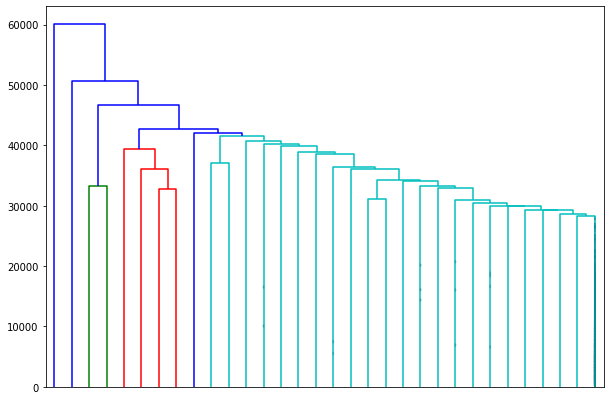

Purity:  0.755
Adjusted RandIndex:  0.4307015325818095
Adjusted Mutual Information:  0.5621352961857744
Homogeneity:  0.8113528969893973


In [9]:
# Agglomerative Hierarchical Clustering (HAC)
# Single-Link assigns
headers.append("Hierarchical\n Single-Link")
single_link = h.single(X)
show_dendrogram(single_link)
get_metrics(y_true, get_clusters(single_link), "single-link")

#### Complete-Link

The **Complete-Link** criterion forms clusters based on the distance between their most distant examples, starting with those where this measure is greatest.

This strategy forms much more compact and similar clusters, but is susceptible to outliers.

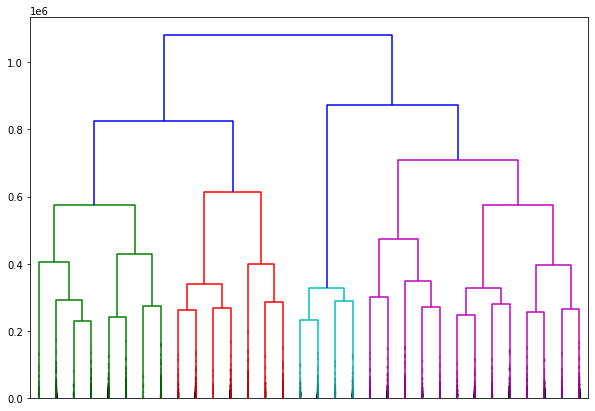

Purity:  0.9222
Adjusted RandIndex:  0.01912531397274304
Adjusted Mutual Information:  0.2672925346488844
Homogeneity:  0.9492775592393842


In [10]:
# Agglomerative Hierarchical Clustering (HAC)
# Complete-Link assigns
headers.append("Hierarchical\n Complete-Link")
complete_link = h.complete(X)
show_dendrogram(complete_link)
get_metrics(y_true, get_clusters(complete_link), "complete-link")

#### Centroid

The **Centroid** criterion measures the similarity between the centroids of the clusters, preferring to join those closest to each other.

This procedure is not always monotonic in merging clusters, making clustering incorrect.

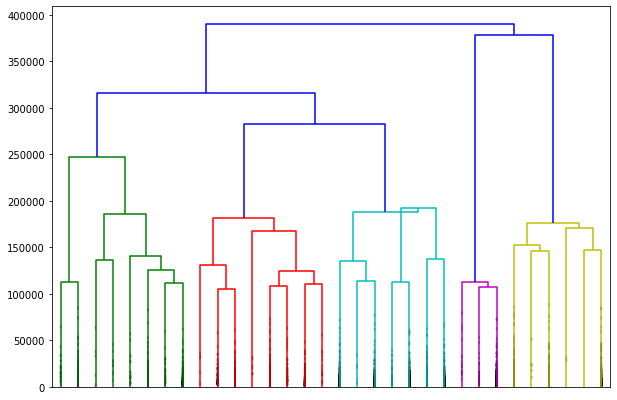

Purity:  0.9162
Adjusted RandIndex:  0.06060928266093396
Adjusted Mutual Information:  0.34091466317111513
Homogeneity:  0.9383382092139789


In [11]:
# Agglomerative Hierarchical Clustering (HAC)
# Centroid assigns
headers.append("Hierarchical\n Centroid")
centroid = h.centroid(X)
show_dendrogram(centroid)
get_metrics(y_true, get_clusters(centroid), "centroid")

#### Average-Link

The **Average-Link** criterion deals with the merging of clusters with the highest average of the distances calculated between all pairs of examples of two clusters.

This procedure is often very robust, as it has no particular disadvantages, such as those discussed above.

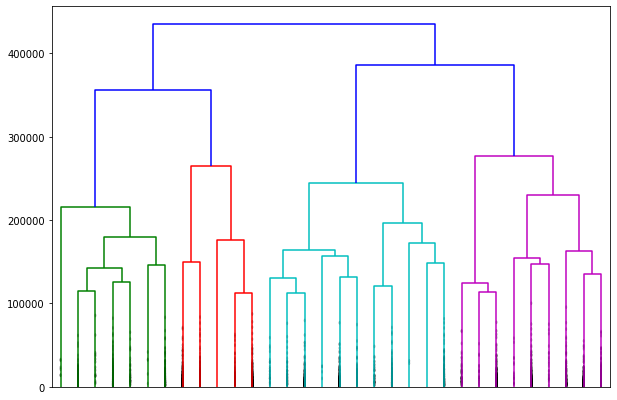

Purity:  0.918
Adjusted RandIndex:  0.04380987401367322
Adjusted Mutual Information:  0.32340612482080544
Homogeneity:  0.9407018920847462


In [12]:
# Agglomerative Hierarchical Clustering (HAC)
# Average-Link assigns
headers.append("Hierarchical\n Average-Link")
average_link = h.average(X)
show_dendrogram(average_link)
get_metrics(y_true, get_clusters(average_link), "average-link")

## Comparison

In [14]:
# Show the results for the clustering algorithm
print_report = [[dictio[i] for i in dictio] for dictio in report]
print(tabulate(print_report, headers=headers, tablefmt="rst"))

===========================  =========  ==============  ================  ==============  ===============
Clustering                     K-Means    Hierarchical      Hierarchical    Hierarchical     Hierarchical
                                           Single-Link     Complete-Link        Centroid     Average-Link
===========================  =========  ==============  ================  ==============  ===============
Purity                        0.808           0.755            0.9222          0.9162           0.918
Adjusted RandIndex            0.676402        0.430702         0.0191253       0.0606093        0.0438099
Adjusted Mutual Information   0.777232        0.562135         0.267293        0.340915         0.323406
Homogeneity                   0.774492        0.811353         0.949278        0.938338         0.940702
===========================  =========  ==============  ================  ==============  ===============


## Conclusions

In conclusion, we have seen that for this dataset K-Means has produced much more refined clusters than hierarchical algorithms.\
The advantage of the K-Means algorithm is that the number of clusters to be created was known in advance.

Among the hierarchical algorithms, comparing the RandIndex, the Single-Link worked best.\
However, there is a difference in accuracy compared to K-Means.